# Building the classification model

This notebook will work with the dataset, preprocess and improve it, and then train the model, just to make a
great classifier for our tests.

Let's first import our needed packages!

## Importing needed packages

We are going to use NLTK to help on preprocessing and Sklearn to make the classification! 

In [116]:
%matplotlib inline

import nltk
import pickle
import unidecode
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from joblib import dump, load
from string import punctuation
from nltk.corpus import stopwords
from nltk import tokenize, FreqDist
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Taking a look at the dataset

Before doing anything, we need to get to know our dataset, it's very important to understand what is good and what
we can imporve on it! This kind of job may be a little hard at the begining, but it will save us a lot of time later!

In [83]:
reviews = pd.read_csv('/data/imdb-reviews-pt-br.csv')

In [84]:
reviews.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [85]:
print('This is a negative review:\n\n', reviews.text_pt[0])

This is a negative review:

 Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar um

In [86]:
reviews.sentiment.unique()

array(['neg', 'pos'], dtype=object)

In [87]:
reviews.sentiment.value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

In [88]:
reviews['binary_sentiment_repres'] = reviews.sentiment.replace(['neg', 'pos'], [0,1])
reviews.head()

,id,text_en,text_pt,sentiment,binary_sentiment_repres
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


In [91]:
whiteSpaceTokenizer = tokenize.WhitespaceTokenizer()

def get_occurs_df(column):
    all_words = ' '.join([item for item in reviews[column]])
    review_tokens = whiteSpaceTokenizer.tokenize(all_words)
    occurencies = FreqDist(review_tokens)
    return pd.DataFrame({
        'words': list(occurencies.keys()), 
        'occur': list(occurencies.values())
    })

In [92]:
def plot_samples(df, n=10):
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=df.nlargest(columns='occur', n=n), x="words", y="occur", color='green')
    ax.set(ylabel='Count')
    plt.show()

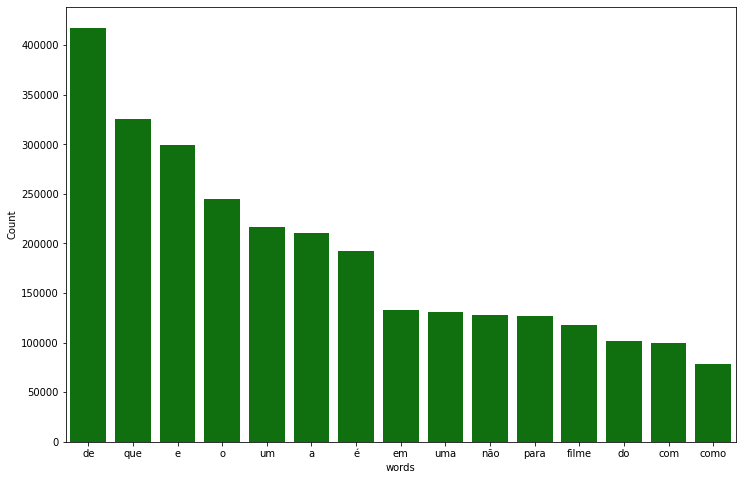

In [93]:
df_occur = get_occurs_df('text_pt')
plot_samples(df_occur, n=15)

## Preprocessors

It's a very good practice preprocess the text before using it in a classification text. Usually, there are a lot of 
trash on the text, or uneeded word.

In [105]:
# Download needed data

nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [95]:
# Transforming everything to lowercase

reviews['preprocess_0'] = [review.lower() for review in reviews.text_pt]

In [96]:
print('This is a negative review:\n\n', reviews.preprocess_0[0])

This is a negative review:

 mais uma vez, o sr. costner arrumou um filme por muito mais tempo do que o necessário. além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. a maioria de nós tem fantasmas no armário, e o personagem costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. o personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, ashton kutcher. o problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. seu único obstáculo parece estar vencendo costner. finalmente, quando estamos bem além do meio do caminho, costner nos conta sobre os fantasmas dos kutchers. somos informados de por que kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. nenhuma mágica aqui, era tudo que eu podia fazer para não desligar um

In [97]:
# First preprocess, taking out the stopwords and ponctuations

irrelevants = stopwords.words("portuguese")

processed_sentece = list()
for each in tqdm(reviews.preprocess_0):
    filtered_sentence = list()
    wordish = whiteSpaceTokenizer.tokenize(each)
    for item in wordish:
        if item not in irrelevants:
            filtered_sentence.append(item)
    processed_sentece.append(' '.join(filtered_sentence))

reviews['preprocess_1_1'] = processed_sentece    

100%|██████████| 49459/49459 [00:21<00:00, 2329.44it/s]


In [98]:
print('This is a negative review:\n\n', reviews.preprocess_1_1[0])

This is a negative review:

 vez, sr. costner arrumou filme tempo necessário. além terríveis seqüências resgate mar, quais poucas, simplesmente importei nenhum personagens. maioria fantasmas armário, personagem costers realizado logo início, esquecido tarde, importava. personagem deveríamos importar arrogante superconfiante, ashton kutcher. problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado. único obstáculo parece estar vencendo costner. finalmente, bem além meio caminho, costner conta sobre fantasmas kutchers. informados kutcher levado ser melhor pressentimentos presságios anteriores. nenhuma mágica aqui, tudo podia fazer desligar hora.


In [99]:
punctuationTokenizer = tokenize.WordPunctTokenizer()

processed_sentece = list()
for each in tqdm(reviews.preprocess_1_1):
    filtered_sentence = list()
    wordish = punctuationTokenizer.tokenize(each)
    for item in wordish:
        if item not in [p for p in punctuation]:
            filtered_sentence.append(item)
    processed_sentece.append(' '.join(filtered_sentence))

reviews['preprocess_1_2'] = processed_sentece    

100%|██████████| 49459/49459 [00:18<00:00, 2706.48it/s]


In [100]:
print('This is a negative review:\n\n', reviews.preprocess_1_2[0])

This is a negative review:

 vez sr costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora


In [101]:
# Second preprocess, taking out accentuation

reviews['preprocess_2'] = [unidecode.unidecode(review) for review in reviews['preprocess_1_2']]
irrelavantes_without_accentuation = [unidecode.unidecode(each) for each in irrelevants]

processed_sentece = list()
for each in tqdm(reviews['preprocess_2']):
    filtered_sentence = list()
    wordish = whiteSpaceTokenizer.tokenize(each)
    for item in wordish:
        if item not in irrelavantes_without_accentuation:
            filtered_sentence.append(item)
    processed_sentece.append(' '.join(filtered_sentence))

reviews['preprocess_2'] = processed_sentece    

100%|██████████| 49459/49459 [00:18<00:00, 2622.68it/s]


In [102]:
print('This is a negative review:\n\n', reviews.preprocess_2[0])

This is a negative review:

 vez sr costner arrumou filme tempo necessario alem terriveis sequencias resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armario personagem costers realizado logo inicio esquecido tarde importava personagem deveriamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armario desordenado unico obstaculo parece estar vencendo costner finalmente bem alem meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos pressagios anteriores nenhuma magica aqui tudo podia fazer desligar hora


In [107]:
# Third, stemming the words to a common radical

stemmer = nltk.RSLPStemmer()

processed_sentece = list()
for each in tqdm(reviews['preprocess_2']):
    filtered_sentence = list()
    wordish = whiteSpaceTokenizer.tokenize(each)
    for item in wordish:
        filtered_sentence.append(stemmer.stem(item))
    processed_sentece.append(' '.join(filtered_sentence))

reviews['preprocess_3'] = processed_sentece   

100%|██████████| 49459/49459 [04:55<00:00, 167.21it/s]


In [108]:
print('This is a negative review:\n\n', reviews.preprocess_3[0])

This is a negative review:

 vez sr costn arrum film temp necessari alem terri sequenc resgat mar qual pouc simples import nenhum person maior fantasm armari person cost realiz log inici esquec tard import person deveri import arrog superconfi ashton kutch problem sai garot pens melhor qualqu outr pesso redor mostr sinal armari desorden unic obstacul parec est venc costn final bem alem mei caminh costn cont sobr fantasm kutch inform kutch lev ser melhor pressent pressagi anteri nenhum magic aqu tud pod faz deslig hor


In [109]:
reviews.head()

,id,text_en,text_pt,sentiment,binary_sentiment_repres,preprocess_0,preprocess_1_1,preprocess_1_2,preprocess_2,preprocess_3
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"mais uma vez, o sr. costner arrumou um filme p...","vez, sr. costner arrumou filme tempo necessári...",vez sr costner arrumou filme tempo necessário ...,vez sr costner arrumou filme tempo necessario ...,vez sr costn arrum film temp necessari alem te...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,este é um exemplo do motivo pelo qual a maiori...,exemplo motivo maioria filmes ação mesmos. gen...,exemplo motivo maioria filmes ação mesmos gené...,exemplo motivo maioria filmes acao mesmos gene...,exempl motiv maior film aca mesm gener chat na...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"primeiro de tudo eu odeio esses raps imbecis, ...","primeiro tudo odeio raps imbecis, poderiam agi...",primeiro tudo odeio raps imbecis poderiam agir...,primeiro tudo odeio raps imbecis poderiam agir...,prim tud odei rap imbecil pod agir arm pressio...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,nem mesmo os beatles puderam escrever músicas ...,beatles puderam escrever músicas todos gostass...,beatles puderam escrever músicas todos gostass...,beatles puderam escrever musicas todos gostass...,beatl pud escrev music tod gost emb walt hill ...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,filmes de fotos de latão não é uma palavra apr...,"filmes fotos latão palavra apropriada eles, ve...",filmes fotos latão palavra apropriada eles ver...,filmes fotos latao palavra apropriada verdade ...,film fot lata palavr apropri verdad tant ous q...


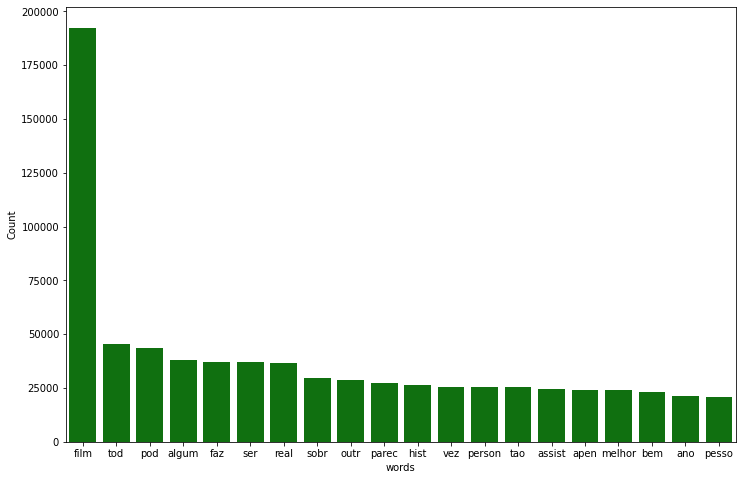

In [111]:
df_occur = get_occurs_df('preprocess_3')
plot_samples(df_occur, n=20)

In [150]:
# Saving the current dataset with preprocessing

reviews.to_csv('imdb-reviews-pt-br2.csv')

## Training our model on the preprocessed dataset

Bellow we are going to train our model, to be easier, we are going to use sklearn simple classifier.

In [133]:
def make_a_prediction(phrase, regressor, vectorizer):
    #return 'Positive' if regressor.predict(vectorizer.transform([phrase]))[0] else 'Negative'
    return regressor.predict(vectorizer.transform([phrase]))[0]

In [151]:
vectorizer_1 = CountVectorizer(max_features=500) # max_features=100

# If you want to put everything on a sparse DataFrame, but is not a good idea!
# bow = vectorizer.fit_transform(reviews.text_pt)
# df_bow = pd.DataFrame.sparse.from_spmatrix(bow, columns=vectorizer.get_feature_names())

bow = vectorizer_1.fit_transform(reviews.preprocess_3)
print("Bag of words shape", bow.shape)

trX, teX, trY, teY = train_test_split(bow, reviews.binary_sentiment_repres.values.reshape(-1, 1), random_state=9)
print("Train and Test X shapes:", trX.shape, teX.shape)
print("Train and Test Y shapes:", trY.shape, teY.shape)

regressor_1 = LogisticRegression(solver="lbfgs")
regressor_1.fit(trX, trY.ravel())
print("acc:", regressor_1.score(teX, teY.ravel()))

Bag of words shape (49459, 500)
Train and Test X shapes: (37094, 500) (12365, 500)
Train and Test Y shapes: (37094, 1) (12365, 1)
acc: 0.8349373230893652


In [152]:
for _ in range(2):
    phrase = input('Digite o que achou do Filme "De volta para o Futuro": ')
    print(make_a_prediction(phrase, regressor_1, vectorizer_1))

Digite o que achou do Filme "De volta para o Futuro": Bom
1
Digite o que achou do Filme "De volta para o Futuro": Ruim
0


In [143]:
vectorizer_2 = TfidfVectorizer(max_features=500)  # lowercase=False, max_features=100

bow = vectorizer_2.fit_transform(reviews.preprocess_3)
print("Bag of words shape", bow.shape)

trX, teX, trY, teY = train_test_split(bow, reviews.binary_sentiment_repres.values.reshape(-1, 1), random_state=9)
print("Train and Test X shapes:", trX.shape, teX.shape)
print("Train and Test Y shapes:", trY.shape, teY.shape)

regressor_2 = LogisticRegression(solver="lbfgs")
regressor_2.fit(trX, trY.ravel())
print("acc:", regressor_2.score(teX, teY.ravel()))

Bag of words shape (49459, 500)
Train and Test X shapes: (37094, 500) (12365, 500)
Train and Test Y shapes: (37094, 1) (12365, 1)
acc: 0.8351799433885968


In [145]:
for _ in range(2):
    phrase = input('Digite o que achou do Filme "Os Vingadores": ')
    print(make_a_prediction(phrase, regressor_2, vectorizer_2))

Digite o que achou do Filme "Os Vingadores": Ruim
0
Digite o que achou do Filme "Os Vingadores": Horrível
0


## Persisting data on disk to be used later on the API

we are going to use JOBLIB to help on it!

https://scikit-learn.org/stable/modules/model_persistence.html#persistence-example

In [146]:
dump(regressor_2, 'sklearn-logistc-regressor-model.joblib') 

['sklearn-logistc-regressor-model.joblib']

In [147]:
pickle.dump(vectorizer_2, open("vectorizer_1.pickle", "wb"))